# 最低共同祖先

在本教程中，我们将探讨 NetworkX 中最低共同祖先算法的 Python 实现 [^1]，位于 [`networkx/algorithms/lowest_common_ancestor.py`](https://github.com/networkx/networkx/blob/main/networkx/algorithms/lowest_common_ancestors.py)。本笔记本假设读者熟悉 NetworkX API。如果您是 NetworkX 的新手，可以先阅读[入门教程](https://networkx.org/documentation/latest/tutorial.html)。

## 导入包

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from itertools import chain, count, combinations_with_replacement

## 定义

在深入算法之前，让我们先回顾一下祖先节点和后代节点的概念。

- **祖先：**
  给定一棵有根树，任何位于从根节点到节点 $v$ 的路径上的节点 $u$ 都是 $u$ 的祖先。

- **后代：** 一个节点的后代要么是该节点的子节点，要么是该节点某个后代的后代。

- **最低共同祖先：** 在一棵树中，对于两个节点 $u$ 和 $v$，最低共同祖先是既是 $u$ 又是 $v$ 的祖先的最底层（即最深）节点。


## 示例

通过示例学习概念总是个好主意。考虑以下进化树。我们将绘制它的有向版本并定义祖先/后代关系。

![image:evolutionary tree](images/evol_tree.png)

首先使用 NetworkX 绘制这棵树。

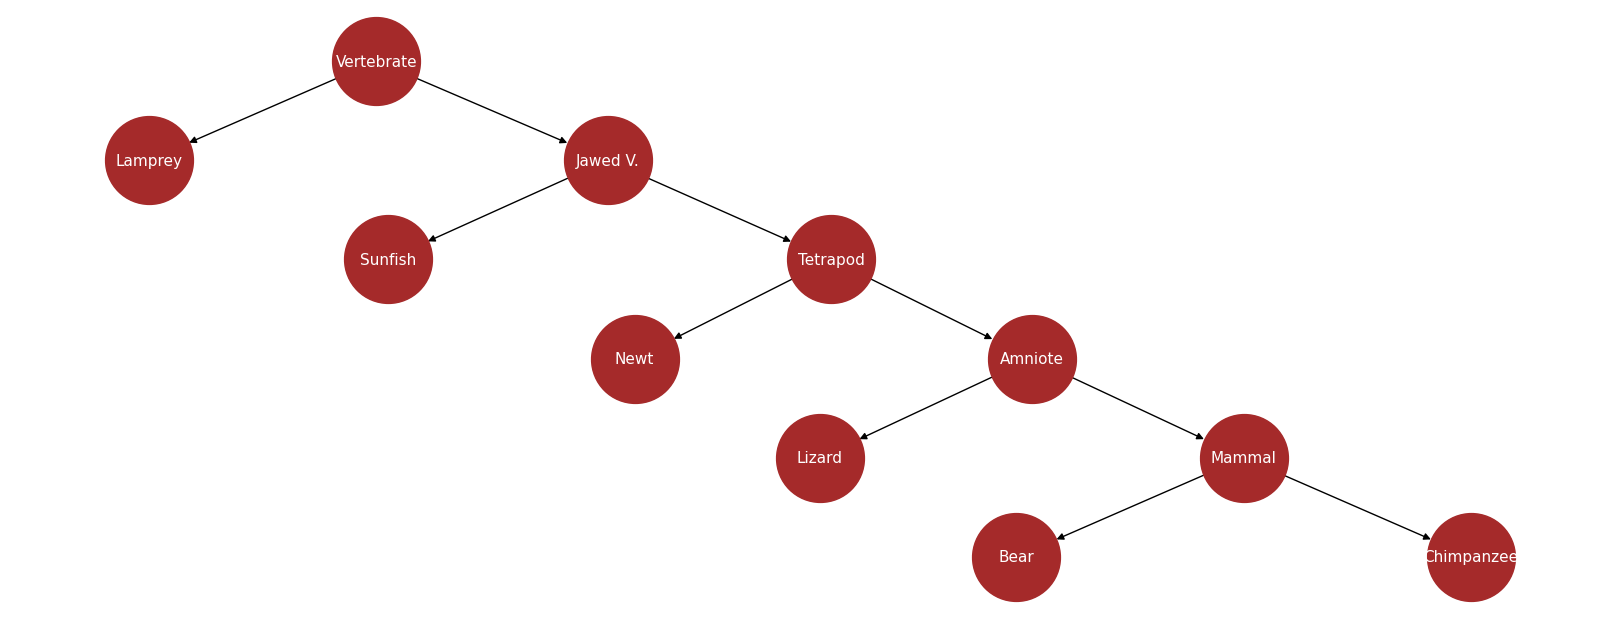

In [2]:
T = nx.DiGraph()
T.add_edges_from(
    [
        ("Vertebrate", "Lamprey"),
        ("Vertebrate", "Jawed V."),
        ("Jawed V.", "Sunfish"),
        ("Jawed V.", "Tetrapod"),
        ("Tetrapod", "Newt"),
        ("Tetrapod", "Amniote"),
        ("Amniote", "Lizard"),
        ("Amniote", "Mammal"),
        ("Mammal", "Bear"),
        ("Mammal", "Chimpanzee"),
    ]
)
pos = graphviz_layout(T, prog="dot")
plt.figure(3, figsize=(16, 6))
nx.draw(
    T,
    pos,
    with_labels=True,
    node_size=4000,
    node_color="brown",
    font_size=11,
    font_color="White",
)
plt.show()

考虑上图并观察以下关系：

- 节点 Mammal 的祖先：
  - 为此，我们将沿着从根到节点 Mammal 的路径。
  - 位于这条路径上的节点 Vertebrate、Jawed Vertebrate、Tetrapod 和 Amniote 都是 Mammal 的祖先。
- 节点 Mammal 的后代：
  - Bear 和 Chimpanzee 是 Mammal 的子节点。因此，它们是 Mammal 的后代。
- Mammal 和 Newt 的最低共同祖先：
  - Mammal 的祖先是 Vertebrate、Jawed Vertebrate、Tetrapod 和 Amniote。
  - Newt 的祖先是 Vertebrate、Jawed Vertebrate 和 Tetrapod。
  - 在共同的祖先中，最底层（即离根最远）的是 Tetrapod。

_注意，在最低共同祖先算法的术语中，每个节点都被视为自身的祖先。_

## NetworkX 的最低共同祖先算法实现

NetworkX 使用一种朴素算法来找到给定节点对的最低共同祖先。在本节中，我们将逐步介绍它。

### 步骤 1：检查输入图是否为 DAG。

NetworkX 中的最低共同祖先算法仅针对至少有一个节点的有向无环图实现。为此，源代码首先检查输入图是否有效。

```python
def naive_all_pairs_lowest_common_ancestor(G, pairs=None):
    if not nx.is_directed_acyclic_graph(G):
        raise nx.NetworkXError("LCA only defined on directed acyclic graphs.")
    elif len(G) == 0:
        raise nx.NetworkXPointlessConcept("LCA meaningless on null graphs.")
```

如果未设置 "pairs" 参数，我们默认考虑 G 中的所有无序节点对，例如，我们不会同时得到 (b, a) 和 (a, b)，而只取其一。如果已经指定了 pairs，我们检查 pairs 中的每个节点是否存在于输入图中。

```python
if pairs is None:
    from itertools import combinations_with_replacement
    pairs = combinations_with_replacement(G, 2)
else:
  pairs = dict.fromkeys(pairs)
  nodeset = set(G)
  for pair in pairs:
      if set(pair) - nodeset:
          raise nx.NodeNotFound(
              f"Node(s) {set(pair) - nodeset} from pair {pair} not in G."
          )
```

### 步骤 2：找到 G 中所有节点的祖先。

一旦输入验证完成，我们找到 pairs 中每个节点的所有祖先，并将这些信息存储在缓存中。
```python
祖先缓存 = {}

for v, w in pairs:
    if v not in 祖先缓存:
        祖先缓存[v] = nx.ancestors(G, v)
        祖先缓存[v].add(v)
    if w not in 祖先缓存:
        祖先缓存[w] = nx.ancestors(G, w)
        祖先缓存[w].add(w)
```
### 步骤 3：寻找共同祖先

对于每一对节点 (v, w)，我们确定同时出现在 $v$ 和 $w$ 的祖先列表中的节点。（即找到所有共同祖先）

```python
common_ancestors = ancestor_cache[v] & ancestor_cache[w]
```

### 步骤 4：在共同祖先中找到位于图中最底层的节点

我们从共同祖先集合中任意选择一个节点 $v$。我们沿着共同祖先集合中剩余的任意出边前进，直到到达一个没有通向其他共同祖先的出边的节点。

```python
v = next(iter(common_ancestors))
while True:
  successor = None
  for w in G.successors(v):
    if w in common_ancestors:
      successor = w
      break
  if successor is None:
      return v
  v = successor
```

我们可以看到算法在一个简单的有向无环图上的结果。假设我们的图 G 如下，并且我们希望找到所有节点对的最小共同祖先。为此，我们需要调用 `all_pairs_lowest_common_ancestor` 方法。

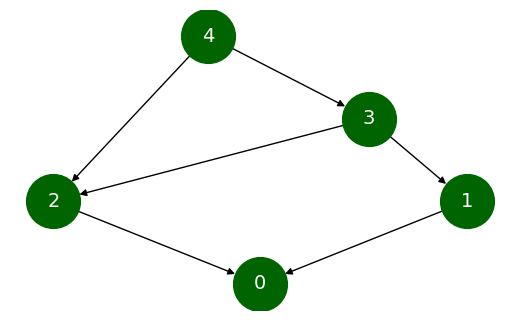

In [3]:
# 生成并可视化我们的有向无环图
G = nx.DiGraph()
G.add_edges_from([(1, 0), (2, 0), (3, 2), (3, 1), (4, 2), (4, 3)])
pairs = combinations_with_replacement(G, 2)

pos = graphviz_layout(G, prog="dot")
plt.figure(3, figsize=(5, 3))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=1500,
    node_color="darkgreen",
    font_size=14,
    font_color="White",
)
plt.show()

In [4]:
dict(nx.all_pairs_lowest_common_ancestor(G))

{(1, 1): 1,
 (1, 0): 1,
 (1, 2): 3,
 (1, 3): 3,
 (1, 4): 4,
 (0, 0): 0,
 (0, 2): 2,
 (0, 3): 3,
 (0, 4): 4,
 (2, 2): 2,
 (2, 3): 3,
 (2, 4): 4,
 (3, 3): 3,
 (3, 4): 4,
 (4, 4): 4}

## 时间与空间复杂度

朴素的最小共同祖先算法会找到给定节点对中所有节点的所有祖先。设给定节点对中的节点数为 P。在最坏情况下，找到单个节点的祖先需要 O(|V|) 时间，其中 |V| 是节点数。因此，构建图的祖先缓存将花费 O(|V|\*P) 时间。这一步骤将主导其他步骤，并决定算法的 worst-case 运行时间。

算法的空間复杂度也将由祖先缓存决定。对于给定节点对中的每个节点，可能会有 O(|V|) 个祖先。因此，空间复杂度也是 O(|V|\*P)。

## 参考文献
[^1]: [Wikipedia, 最小共同祖先](https://en.wikipedia.org/wiki/Lowest_common_ancestor)